# Credit Card Fraud Detection
This notebook is dedicated to the study and prediction of credit card fraud from a large transaction dataset.

## Imports and Globals
***
Getting relevant packages for data exploration, processing, and classification. I also read in the transaction csv file and define some colors I will use for my plots throughout this notebook.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

dataset_file = 'data/creditcard.csv'

cmap = [sns.color_palette('hls')[0], sns.color_palette('hls')[4]]
nonfraud_patch = mpatches.Patch(color='#3b4cc0', label='Non-Fraud')
fraud_patch = mpatches.Patch(color='#b40426', label='Fraud')

df = pd.read_csv(dataset_file)

## A look at the data
***
A quick glance at our dataframe shows us that there are 3 known attributes: {Time, Amount, Class}, and 28 unknown attributes: {V1,...,V28}.

No NULL values is good. In a real scenario, this is unlikely to be the case, but pandas provides plenty of tools for dealing with it.

In [4]:
print('Total number of NULL values:', df.isna().sum().sum())

Total number of NULL values: 0


The unknown attributes were obtained by reducing the dimensions of a larger set of known private attributes. 
- This is done for security purposes. 
- In a production environment, feature engineering would need to be done to select the most important private attributes. 
    - Then a dimensionality reduction technique like PCA could be used if we want a similar dataset.
    - This would not match the data we have here, but we could employ similar EDA techniques to study and classify on the data.

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The **Time** and **Amount** columns can get fairly large (> 20000). I choose to scale the data to regularize it. 
- StandardScaler and RobustScaler are both good choices, I use StandardScaler.

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

These columns are now normalized, which will definitely improve model performance down the line.

In [8]:
df.describe()[['Time', 'Amount']]

,Time,Amount
count,2.848070e+05,2.848070e+05
mean,-3.065637e-16,2.913952e-17
std,1.000002e+00,1.000002e+00
min,-1.996583e+00,-3.532294e-01
25%,-8.552120e-01,-3.308401e-01
50%,-2.131453e-01,-2.652715e-01
75%,9.372174e-01,-4.471707e-02
max,1.642058e+00,1.023622e+02


#### Data Summary - Class Imbalance
***
This data is highly imbalanced! We have over 280k transaction records of which only 0.17% are fraudulent. 
- We will use techniques to balance the data so that our model can properly fit our dataset. 
    - **Undersampling**
        - Random Undersampling:
        - Tomek Links Unersampling:
    - **Oversampling**
        - Sythetic Minority Oversampling Technique (SMOTE):
        - Borderline SMOTE:

In [9]:
def class_distribution(df):
    fraud = round(len(df.loc[df['Class'] == 1]) / len(df) * 100, 2)
    nonfraud = round(len(df.loc[df['Class'] == 0]) / len(df) * 100, 2)
    print('% dataset with class 0: {}%\n% dataset with class 1: {}%\n'.format(nonfraud, fraud))

In [10]:
print('Size of dataset: {} samples'.format(len(df)))
class_distribution(df)

Size of dataset: 284807 samples
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%



## Exploratory Data Analysis

We start by getting a view of the class imbalance with a simple Count plot. Since over 99% of our data is non-fraudulent transactions, it will be almost impossible for our model to do anything other than trivialize the predictions to the majority class.

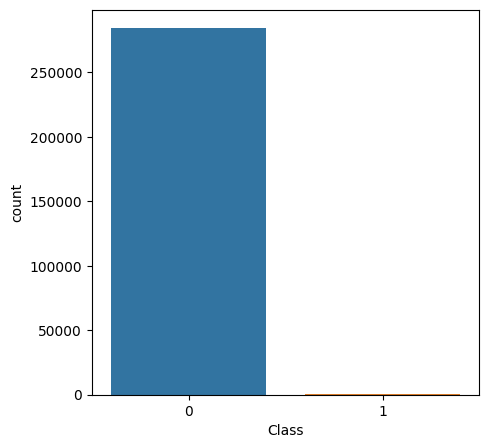

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(x='Class', data=df)

#### Amount and Time distributions
***
To get a sense of the only two attributes we actually know, I chose to first just see the overall distribution. 
- Interestingly enough, since the data was collected over a two day period, the day/night cycle is apparent. This is a form of **data drift** that happens because people buy less stuff when they are asleep :)
- This will also be reflected, in a production system, through seasonal buying patterns. Therefore, whatever model we fit may perform worse if the data comes from an entirely different time in the year.

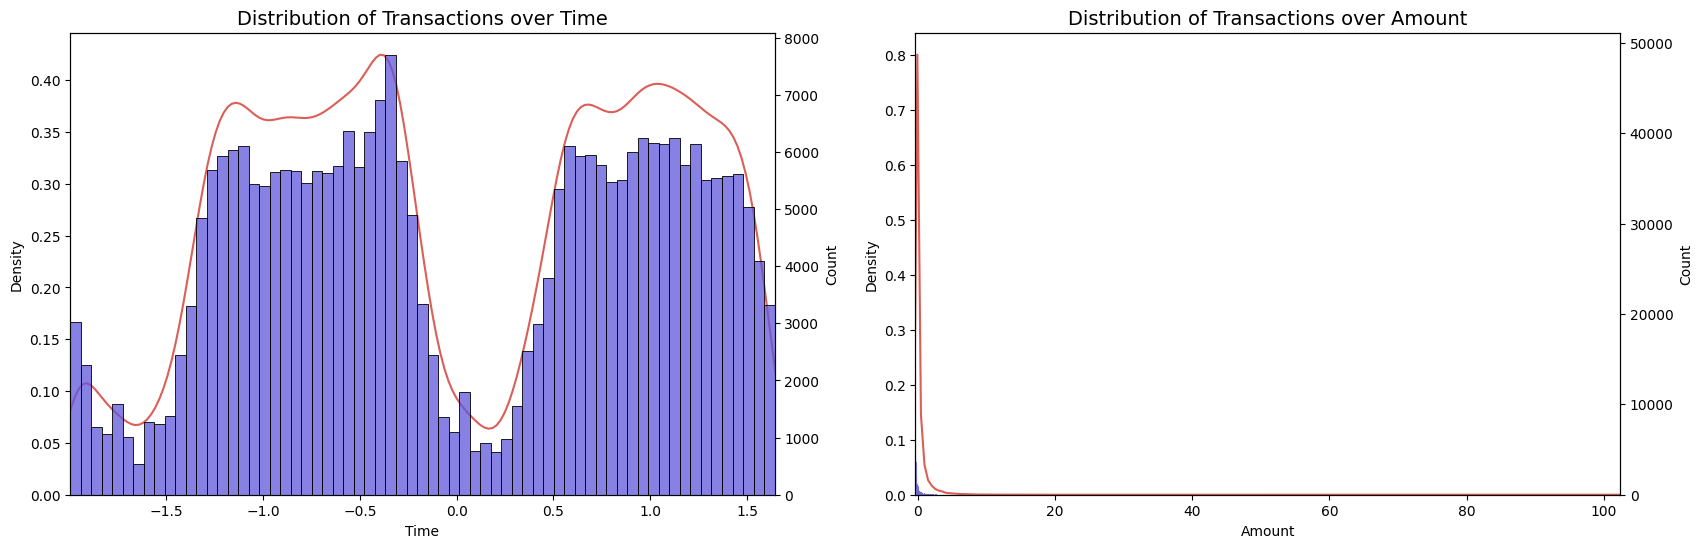

In [13]:
def amount_time_distributions(df):
    _, ax = plt.subplots(1, 2, figsize=(20, 6))
    sns.kdeplot(x='Time', ax=ax[0], data=df, color=cmap[0])
    ax2 = ax[0].twinx()
    sns.histplot(x='Time', ax=ax2, data=df, color=cmap[1])
    ax[0].set_title('Distribution of Transactions over Time', fontsize=14)
    ax[0].set_xlim([min(df['Time']), max(df['Time'])])
    
    sns.kdeplot(x='Amount', ax=ax[1], data=df, color=cmap[0])
    ax2 = ax[1].twinx()
    sns.histplot(x='Amount', ax=ax2, data=df, color=cmap[1])
    ax[1].set_title('Distribution of Transactions over Amount', fontsize=14)
    ax[1].set_xlim([min(df['Amount']), max(df['Amount'])])

    plt.show()

amount_time_distributions(df)

#### Correlation Matrix
***
Given the huge number of 0 samples, it is hard for the correlation matrix to pick up anything. I will perform these same tests on the balanced dataset and compare the differences.

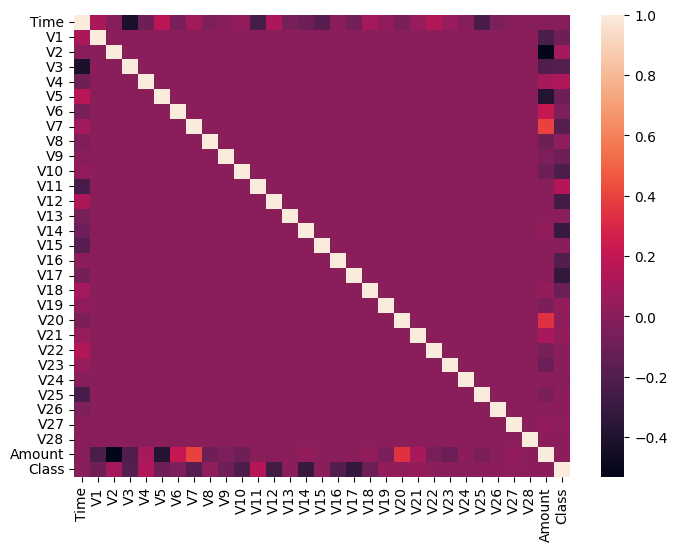

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(df.corr())

## Train and Testset Creation
***
Before balancing the data, I will be splitting it into a training set and a testing set. The test set should come from the original distribution, so we use train_test_split and stratify based on the class distribution.
- The output shows that our distributions are the same. We have less than 100 positive samples in the test set, but this should still be enough to get a gauge of how well the model performs later. 


**holdout_df** will contain the test samples and will not be touched outside model evaluation later.

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(labels=['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
holdout_df = pd.concat([X_test, y_test], axis=1)

print('TRAINING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(len(train_df[train_df.Class == 1]), len(train_df[train_df.Class == 0])))
class_distribution(train_df)

print('TESTING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(len(holdout_df[holdout_df.Class == 1]), len(holdout_df[holdout_df.Class == 0])))
class_distribution(holdout_df)

TRAINING SET
- Fraud class size: 394
- Non-Fraud class size: 227451
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%

TESTING SET
- Fraud class size: 98
- Non-Fraud class size: 56864
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%



## Random Undersampling
***
The main technique employed here, we simply select an equal number of non-fraud samples as we do fraud samples. 

Performing random undersampling! Just randomly choose equal portion non-fraud samples and fraud samples. Since there are more non-fraud samples, we only have to portion down this field, and we keep all the fraud-samples.

In [16]:
new_df = train_df.groupby('Class', group_keys=False).apply(lambda x: x.sample(len(train_df[train_df.Class == 1])))
print(len(new_df))

788


### EDA - Random Undersampling

The Count plot shows that our dataset is now evenly distributed with less than 800 samples remaining.

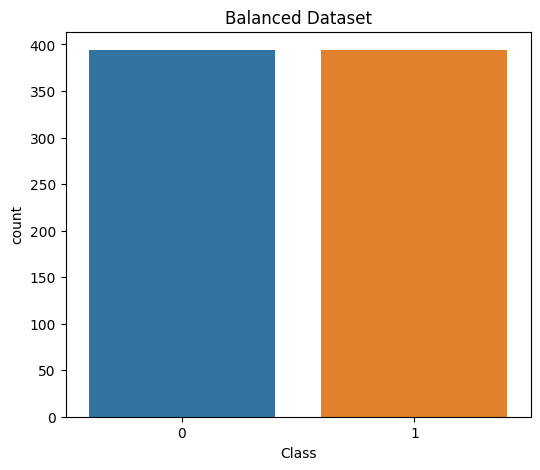

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(x='Class', data=new_df)
plt.title('Balanced Dataset')
plt.show()

#### Correlation Matrix
***
- Now that the data is balanced, the correlation matrix is showing some useful information!
- When comparing the correlations of {V1,...,V28} to the Class (Fraudulent or Non-Fraudulent), we notice that features V1-V18 appear to have the strongest correlations.
    - I expect these will be helpful predictors for the model later on.
- Features like V21 and V22 are strongly correlated, neither seems to be correlated to the Class in any particular way, so this information alone may not be directly useful for predicting the class. 
- I will focus visualizations on the features which have a decent correlation with the Class
    - correlation $\geq 0.5$:
    - The specific intervals can be modified to consider more or less features.
***
The code I wrote allows for more modular data exploration, allowing for more or less features to be considered from trimming and analysis depending on the values chosen. Feel free to change these values to see how other features correlate to the class and remove outliers from them as well!

Correlation matrix on balanced data. Features with strong correlation with Class are selected for further exploration.

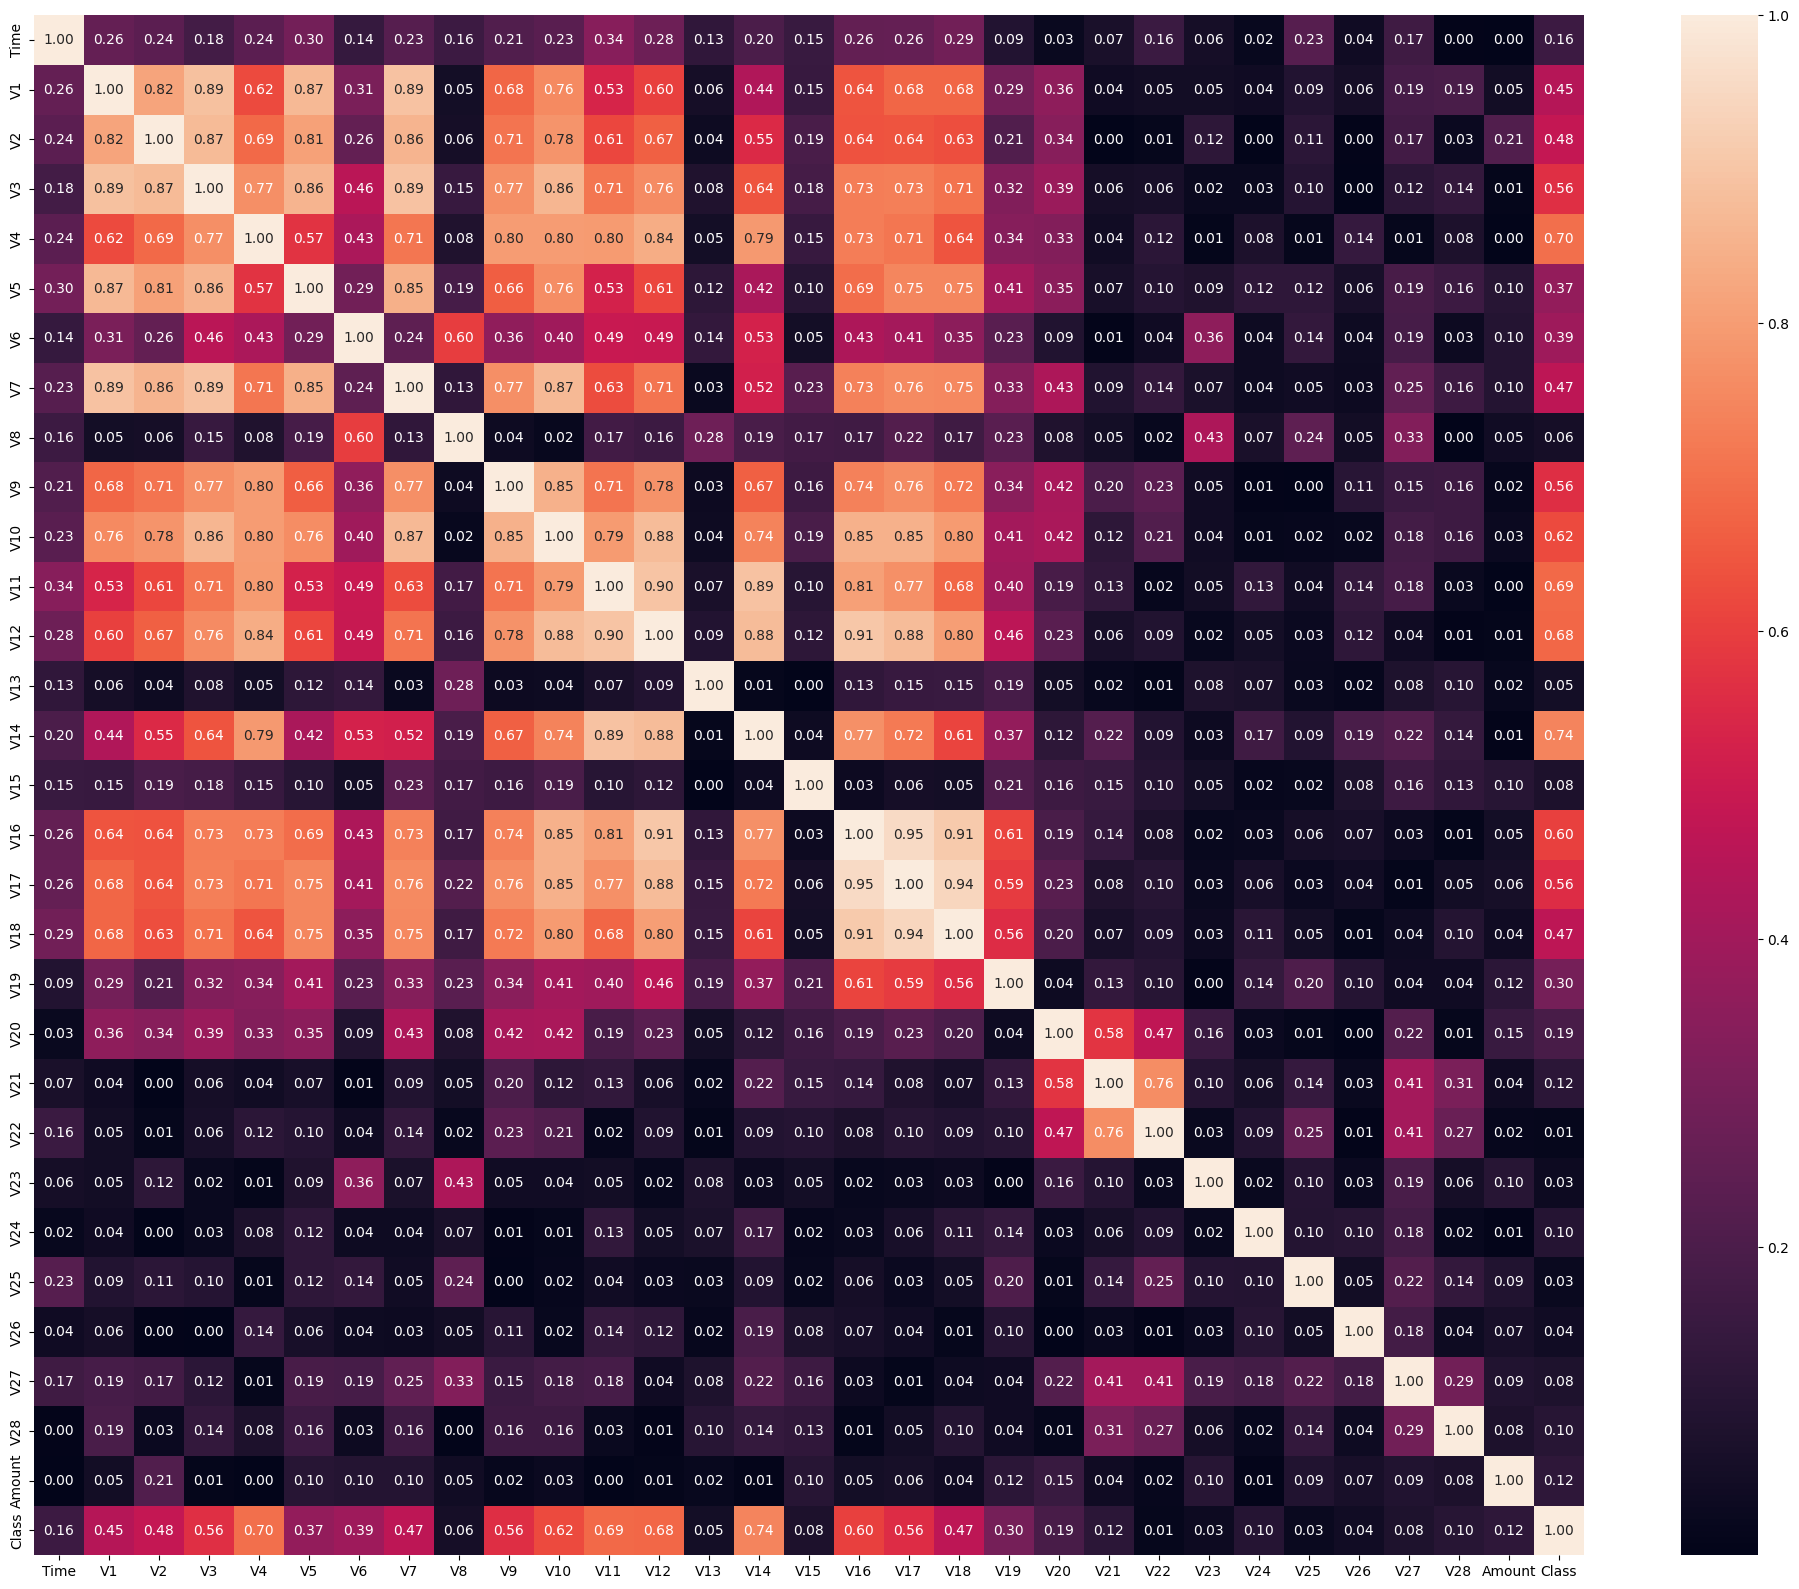

In [18]:
corr = abs(new_df.corr())

fig, ax = plt.subplots(figsize=(25, 20))
ax = sns.heatmap(corr, annot=True, fmt=".2f")

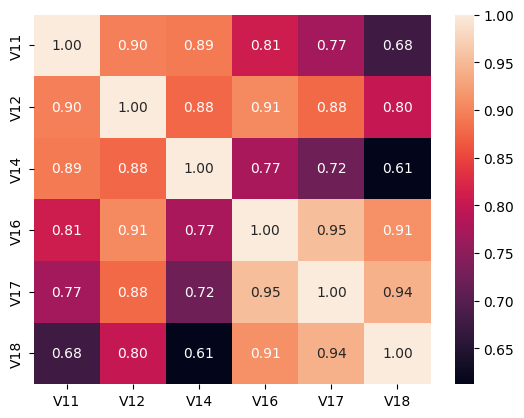

In [19]:
new_corr = abs(new_df[['V11', 'V12', 'V14', 'V16', 'V17', 'V18']].corr())
sns.heatmap(new_corr, annot=True, fmt='.2f')
plt.show()

In [20]:
def get_high_corr_feats(df, min_val, excluded_feats=['Class', 'Class Name', 'Class Dist'], summary=True):
    class_corr = abs(df.corr()['Class'])
    # don't include class for this (1 correlation with itself)
    corr_feats = class_corr.loc[(class_corr >= min_val) & (~class_corr.index.isin(excluded_feats))]
    
    if summary:
        print('Features Strongly Correlated with Class')
        for idx in corr_feats.index:
            print(idx, corr_feats[idx])

    return corr_feats

In [21]:
corr_feats = get_high_corr_feats(new_df, min_val=0.6)

Features Strongly Correlated with Class
V4 0.6971770473470295
V10 0.6226195899503667
V11 0.6859174237784277
V12 0.680966349378409
V14 0.7445199883020368
V16 0.6034774217677844


In [25]:
def create_class_names(df, col='Class Name'):
    df.loc[df['Class'] == 1, col] = 'Fraud'
    df.loc[df['Class'] == 0, col] = 'Non-Fraud'
    
    return df

def create_class_distribution(df, col='Class Dist'):
    zero_class_dist = np.random.normal(loc=0, scale=0.1, size=len(df.loc[df['Class'] == 0]))
    one_class_dist = np.random.normal(loc=1, scale=0.1, size=len(df.loc[df['Class'] == 1]))

    df.loc[df['Class'] == 0, col] = zero_class_dist
    df.loc[df['Class'] == 1, col] = one_class_dist
    
    return df

new_df = create_class_names(new_df)
new_df = create_class_distribution(new_df)

In [43]:
def plot_joint_distribution(df, corr_feats, x_label='Class Dist', hue='Class Name'):
    fig, axs = plt.subplots(1, len(corr_feats), figsize=(20, 5))
    for i, feat in enumerate(corr_feats.index):
        sns.kdeplot(data=df, x=x_label, y=feat, ax=axs[i], hue=hue, palette=cmap)
        axs[i].set_title('{} vs. Class Distribution - Correlation: {}'.format(feat, round(corr_feats[feat], 3)))
        plt.suptitle('Joint Distribution of Features and Class')

    plt.tight_layout(w_pad=10.0)
    plt.show()

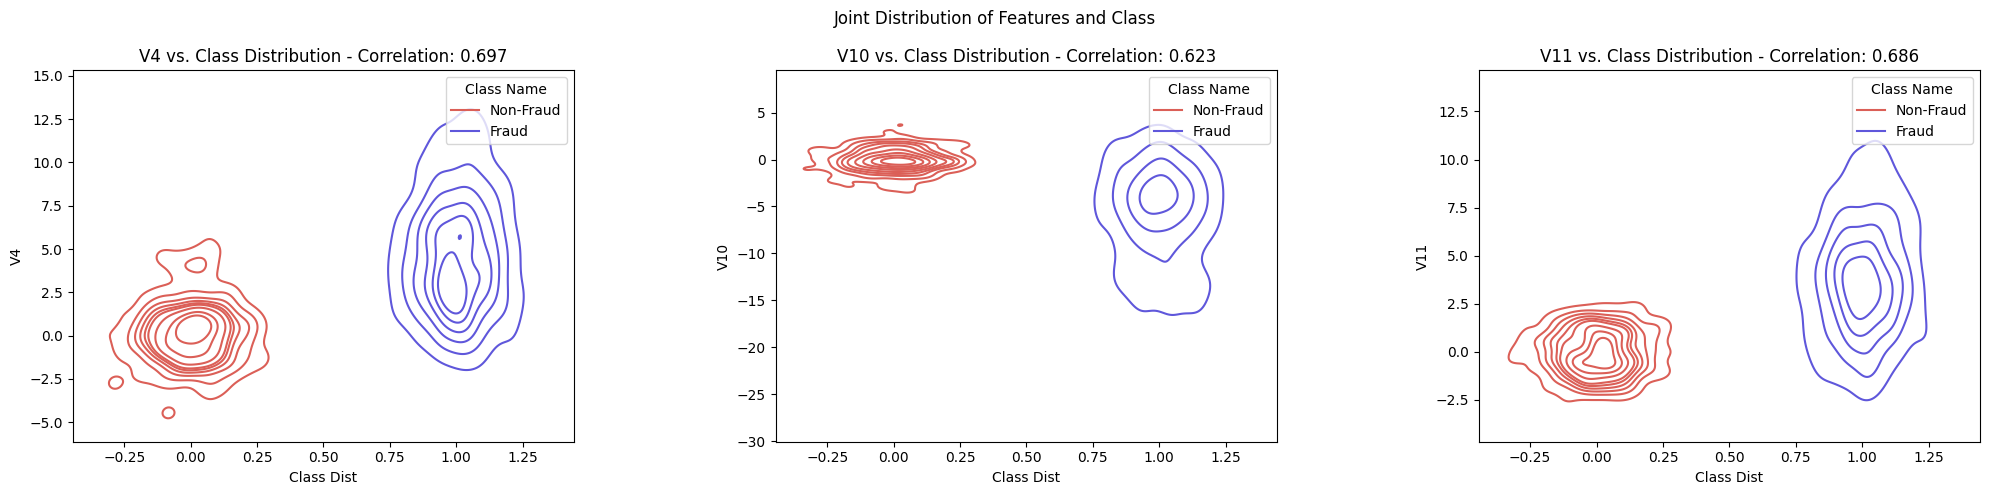

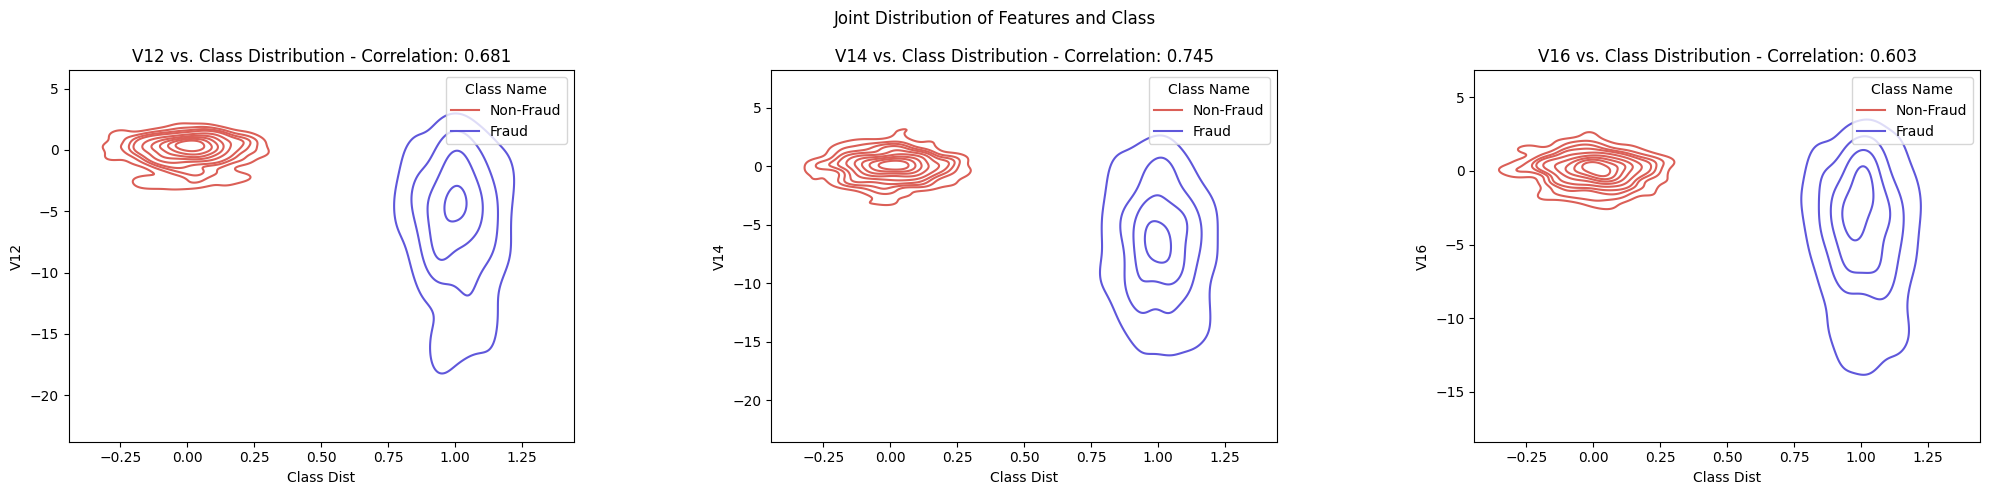

In [45]:
plot_joint_distribution(new_df, corr_feats[:len(corr_feats) // 2])
plot_joint_distribution(new_df, corr_feats[len(corr_feats) // 2:])

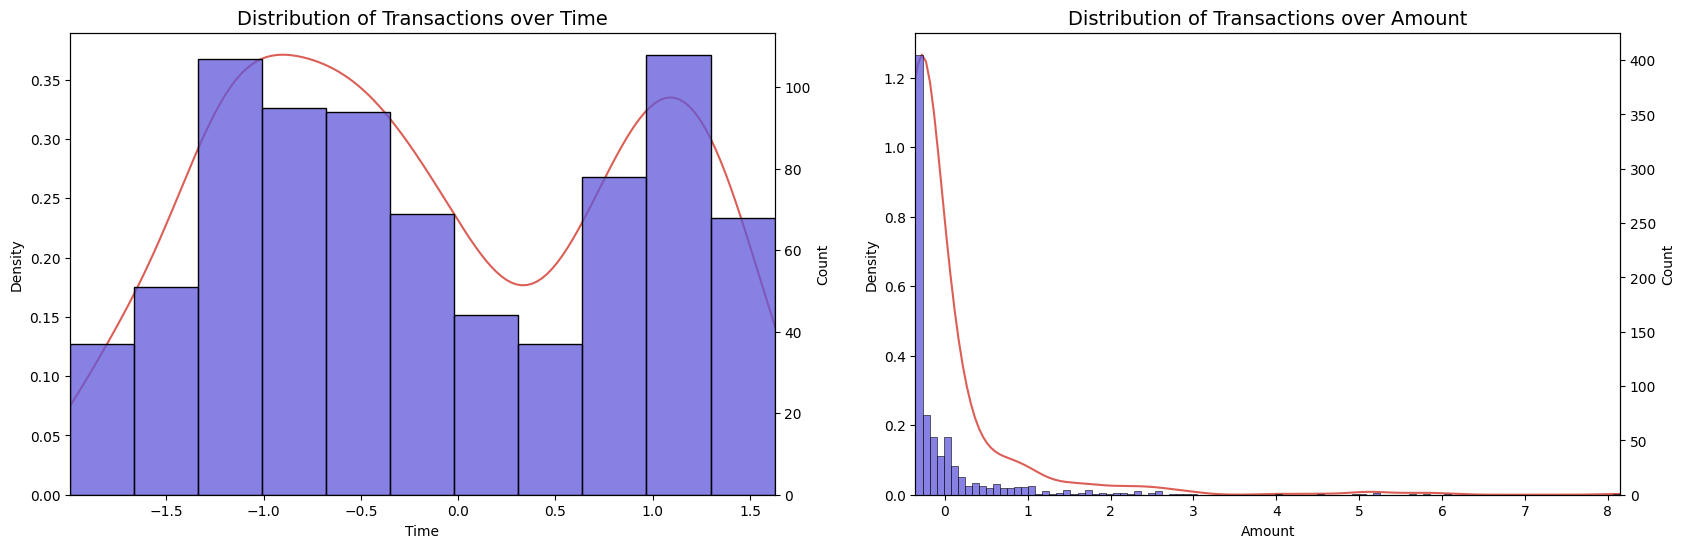

In [46]:
amount_time_distributions(new_df)

In [47]:
def get_irq_from_dataframe(df):
    lower_quartile = df.quantile(0.25)
    upper_quartile = df.quantile(0.75)
    return upper_quartile - lower_quartile, lower_quartile, upper_quartile

def trim_outliers(df, irq, lower_quartile, upper_quartile, slice, threshold=1.5):
    lower_bound = lower_quartile - threshold * irq
    upper_bound = upper_quartile + threshold * irq

    outlier_indices = slice[(slice > upper_bound) | (slice < lower_bound)].index
    
    df = df.drop(outlier_indices)

    return df, lower_bound, upper_bound

def show_outliers(df, lower_bound, upper_bound, slice):
    outlier_indices = slice[(slice > upper_bound) | (slice < lower_bound)].index
    noutliers = len(outlier_indices)
    
    outliers = [x for x in slice[outlier_indices]]
    
    print('{} # outliers: {}, {}'.format(slice.name, len(outliers), noutliers))
    print('{} outliers: {}'.format(slice.name, outliers))
    
def trim_outliers_from_corr_features(df, corr_feats, threshold=1.5, summary=True):
    trimmed_df = df.copy()
    # for feats in corr_feats:
    for feat in corr_feats.index:
        feat_fraud = trimmed_df[feat].loc[trimmed_df['Class'] == 1]
        irq, lower_quartile, upper_quartile = get_irq_from_dataframe(feat_fraud)
        
        if summary:
            print(f'FEATURE {feat}:')
            print('Dataset size (pre-trim): ', len(trimmed_df))
            print('\nInterquartile Range: {}\nQuartiles: {}\n'.format(irq, [lower_quartile, upper_quartile]))
            
        trimmed_df, lower_bound, upper_bound = trim_outliers(trimmed_df, irq, lower_quartile, upper_quartile, slice=feat_fraud, threshold=threshold)
        show_outliers(trimmed_df, lower_bound, upper_bound, slice=feat_fraud)
        
        if summary:
            print('Bounds: {}\n'.format([lower_bound, upper_bound]))
            print('Dataset size (post-trim): ', len(trimmed_df))
            print('---'*45)
    
    return trimmed_df

def plot_outliers_removed(df, feats, corr_label='Positively'):
    fig, axs = plt.subplots(1, len(feats), figsize=(5*len(feats),5))
    
    for i, feat in enumerate(feats.index):
        sns.boxplot(x="Class", y=feat, data=df, ax=axs[i], palette=cmap)
        axs[i].set_title(f"{feat} Feature Distribution\nOutliers Removed", fontsize=14)
        axs[i].legend(handles=[nonfraud_patch, fraud_patch])
        
    plt.suptitle(f'Features {corr_label} Correlated with Class')
    plt.tight_layout(w_pad=5.0)
    plt.show()

In [48]:
trimmed_df = trim_outliers_from_corr_features(new_df, corr_feats=corr_feats, threshold=1.5, summary=True)

FEATURE V4:
Dataset size (pre-trim):  788

Interquartile Range: 4.07707175933563
Quartiles: [2.2720032645269947, 6.349075023862625]

V4 # outliers: 0, 0
V4 outliers: []
Bounds: [-3.84360437447645, 12.46468266286607]

Dataset size (post-trim):  788
---------------------------------------------------------------------------------------------------------------------------------------
FEATURE V10:
Dataset size (pre-trim):  788

Interquartile Range: 5.132479628247817
Quartiles: [-7.7957868465138, -2.6633072182659827]

V10 # outliers: 14, 14
V10 outliers: [-24.4031849699728, -22.1870885620007, -22.1870885620007, -22.1870885620007, -16.6496281595399, -23.2282548357516, -24.5882624372475, -20.9491915543611, -19.836148851696, -15.5637913387301, -18.9132433348732, -15.5637913387301, -22.1870885620007, -16.2556117491401]
Bounds: [-15.494506288885525, 5.035412224105743]

Dataset size (post-trim):  774
-------------------------------------------------------------------------------------------------

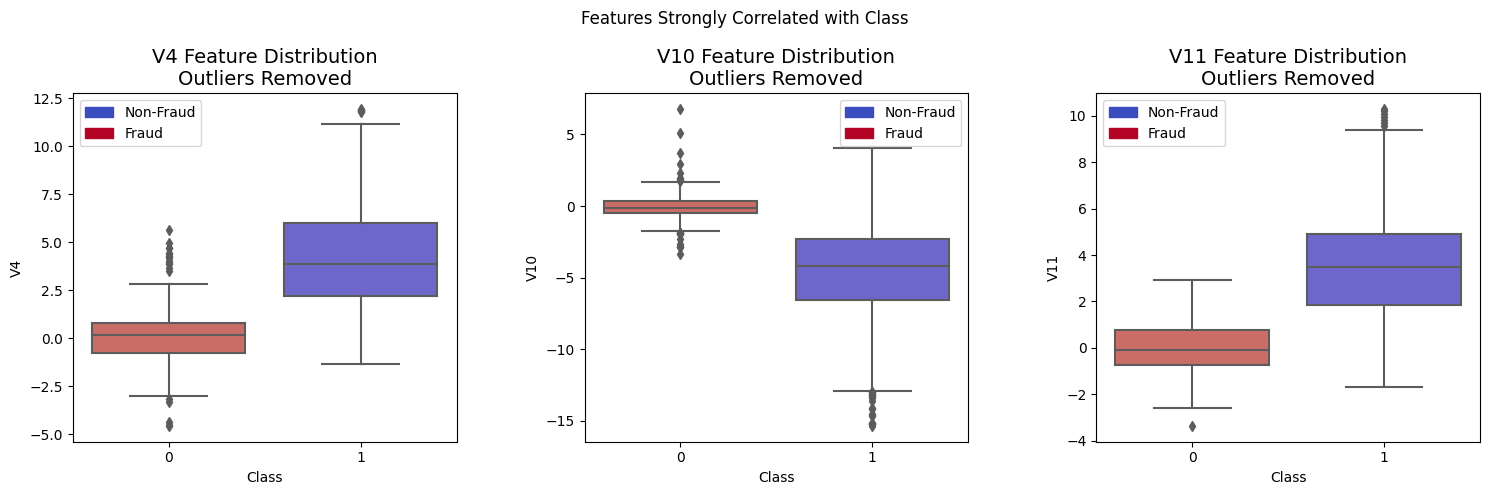

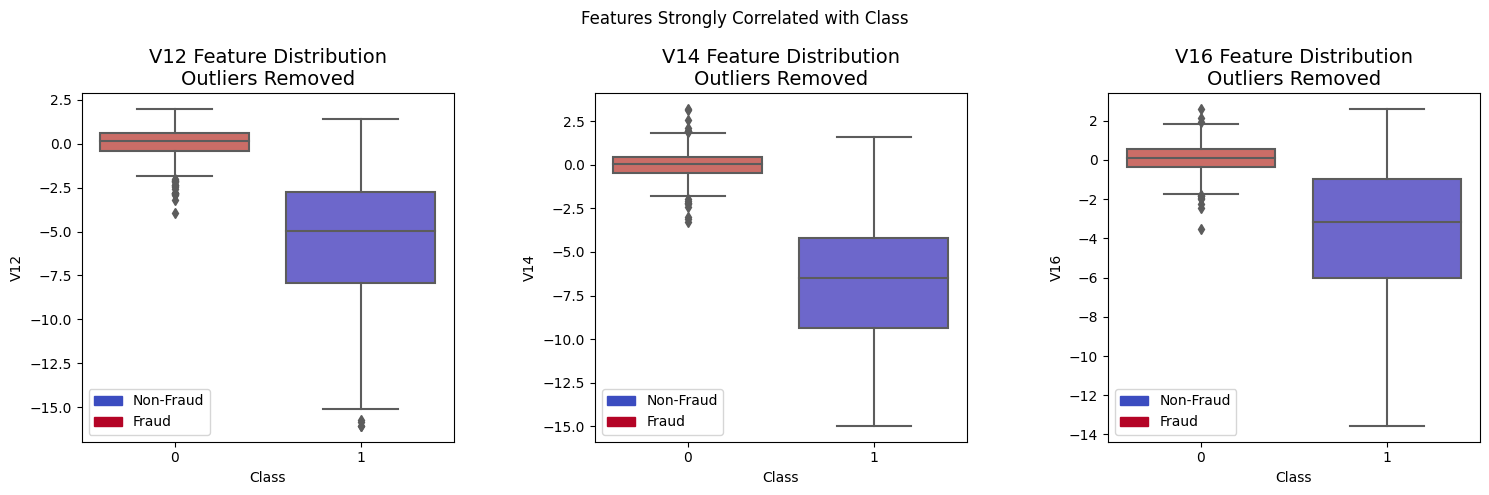

In [49]:
plot_outliers_removed(trimmed_df, corr_feats[:len(corr_feats) // 2], corr_label='Strongly')
plot_outliers_removed(trimmed_df, corr_feats[len(corr_feats) // 2:], corr_label='Strongly')

In [50]:
def plot_reduced_dimensions(df, method='tsne'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    fig.suptitle('Dimensionality Reduction Clustering Visualization')

    X = df.drop(['Class', 'Class Name', 'Class Dist'], axis=1)
    y = df['Class']

    if method == 'tsne':
        X_tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=40).fit_transform(X)
        ax.scatter(X_tsne[:, 0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraud')
        ax.scatter(X_tsne[:, 0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud')
        ax.set_title('t-SNE')
        ax.legend(handles=[nonfraud_patch, fraud_patch])
        plt.show()
        
        return X_tsne
    
    elif method == 'pca':
        X_pca = PCA(n_components=2).fit_transform(X)
        ax.scatter(X_pca[:, 0], X_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraud')
        ax.scatter(X_pca[:, 0], X_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud')
        ax.set_title('PCA')
        ax.legend(handles=[nonfraud_patch, fraud_patch])
        
        return X_pca
    
    else:
        print('Error: Invalid dimensionality reduction method. Please choose a method from ["tsne", "pca"].')
    
    return None

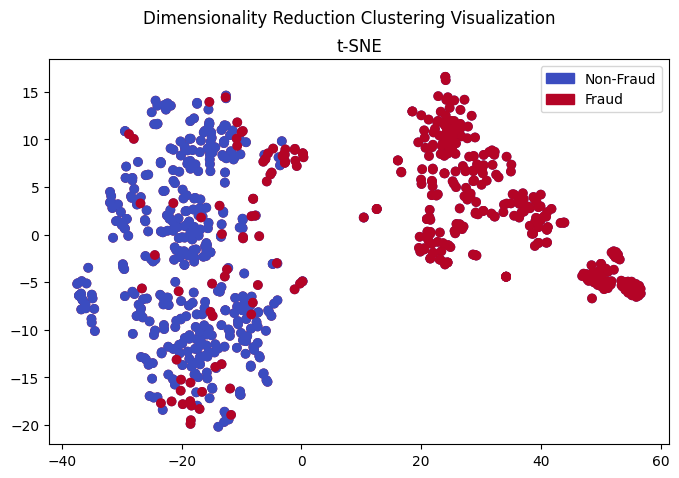

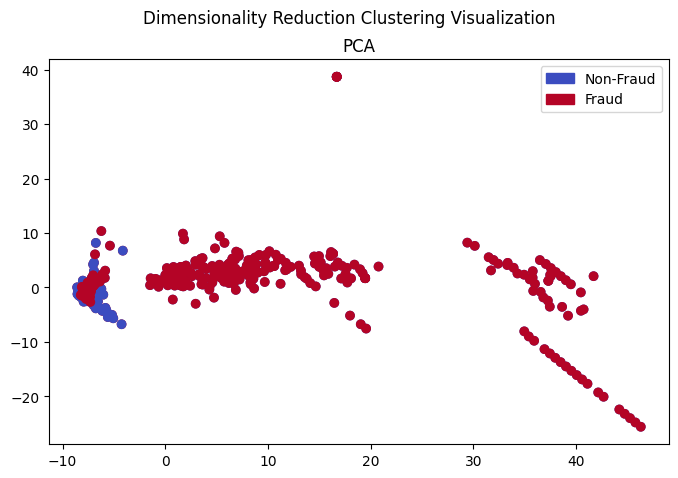

In [51]:
X_tsne = plot_reduced_dimensions(trimmed_df, method='tsne')
X_pca = plot_reduced_dimensions(trimmed_df, method='pca')

## Model Selection and Training

In [52]:
new_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Class Name', 'Class Dist'],
      dtype='object')

In [61]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def evaluate_rfc_crossval(model, X, y, cv=5):
    """
    Evaluates a RandomForestClassifier using cross-validation and returns the average accuracy score.
    
    Parameters:
    - X: The input features as a 2D array or DataFrame.
    - y: The target variable as a 1D array or Series.
    - cv: The number of cross-validation folds (default: 5).
    
    Returns:
    - The average accuracy score across the cross-validation folds.
    """
    
    scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'roc_auc': 'roc_auc'}
    
    # Perform cross-validation and compute the scores
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv)

    avg_accuracy = scores['test_accuracy'].mean()
    avg_precision = scores['test_precision'].mean()
    avg_recall = scores['test_recall'].mean()
    avg_roc_auc = scores['test_roc_auc'].mean()
    
    # Return the average accuracy score
    return {'accuracy': avg_accuracy, 'precision': avg_precision, 'recall': avg_recall, 'roc_auc': avg_roc_auc}

def evaluate_model(model, X, y, label='Random Forest'):
    y_pred = model.predict(X)
    
    acc, precision, recall, roc = accuracy_score(y, y_pred), precision_score(y, y_pred), recall_score(y, y_pred), roc_auc_score(y, y_pred)

    scores = [label, acc, precision, recall, roc]
    scores[1:] = [round(score, 4) for score in scores[1:]]
    scores_df = pd.DataFrame([scores], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'AUC-ROC'])

    plot_confusion_matrix(y, y_pred, label=label)
    
    # Return the average accuracy score
    return scores_df

def plot_confusion_matrix(y_true, y_pred, label='Random Forest'):
    confusion_matrix_ = confusion_matrix(y_true, y_pred)

    # Maps the confusion matrix so each row is a distribution for that row. Easier to visualize.
    # confusion_matrix_ = confusion_matrix_.astype('float') / confusion_matrix_.sum(axis=1).reshape(2, 1)

    sns.heatmap(confusion_matrix_, annot=True)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix - {label}')
    plt.show()

In [62]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split
from IPython.display import HTML


X = new_df.drop(['Class', 'Class Name', 'Class Dist'], axis=1)
y = new_df['Class']
# This is explicitly used for undersampling.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

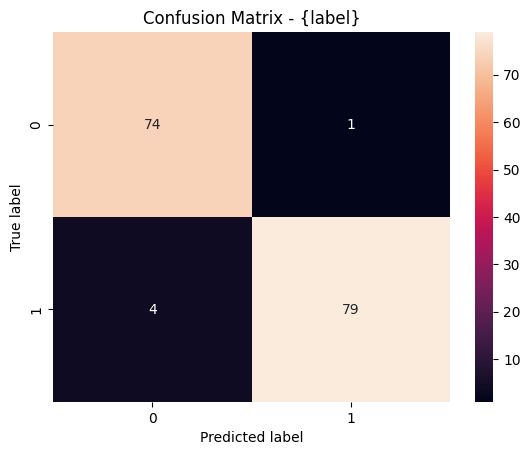

Model,Accuracy,Precision,Recall,AUC-ROC
Random Forest,0.9684,0.9875,0.9518,0.9692


In [63]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy')
rfc.fit(X_train_2, y_train_2)

scores_df = evaluate_model(rfc, X_test_2, y_test_2, label='Random Forest')

HTML(scores_df.head().to_html(index=False))

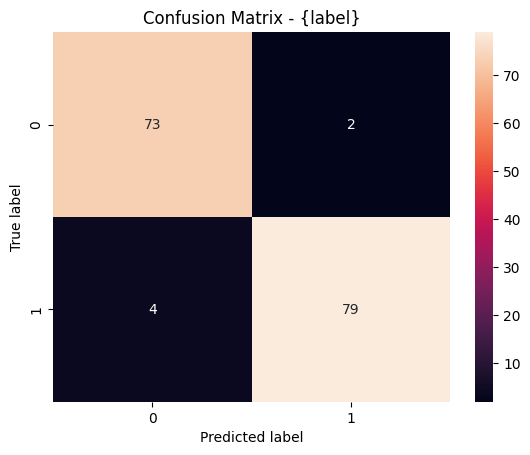

Model,Accuracy,Precision,Recall,AUC-ROC
Logistic Regression,0.962,0.9753,0.9518,0.9626


In [71]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_2, y_train_2)

scores_df = evaluate_model(lr, X_test_2, y_test_2, label='Logistic Regression')

HTML(scores_df.head().to_html(index=False))

In [65]:
from sklearn.metrics import roc_curve
    
def plot_roc_curves(curves):
    def plot_roc_curve(fpr, tpr, label=None, color='b'):
        plt.plot(fpr, tpr, label=label, color=color)
    
    plt.figure(figsize=(15, 10))
    plt.title(f'ROC Curve for Classifiers')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.axis([-.05, 1, 0, 1.05])
    
    palette = sns.color_palette('hls', 8)
        
    for i, name in enumerate(curves):
        fpr, tpr, _ = curves[name]
        plot_roc_curve(fpr, tpr, label=name, color=palette[i])
    
    plt.legend()
    plt.show()
        

def get_roc_curves(models, X, y):
    curves = {}
    
    for name in models:
        y_pred_proba = models[name].predict_proba(X)
        fpr, tpr, threshold = roc_curve(y, y_pred_proba[:, 1])
        
        curves[name] = (fpr, tpr, threshold)
    
    return curves

In [68]:
models = {'Random Forest': rfc, 'Logistic Regression': lr}
roc_curves = get_roc_curves(models, X_test, y_test)

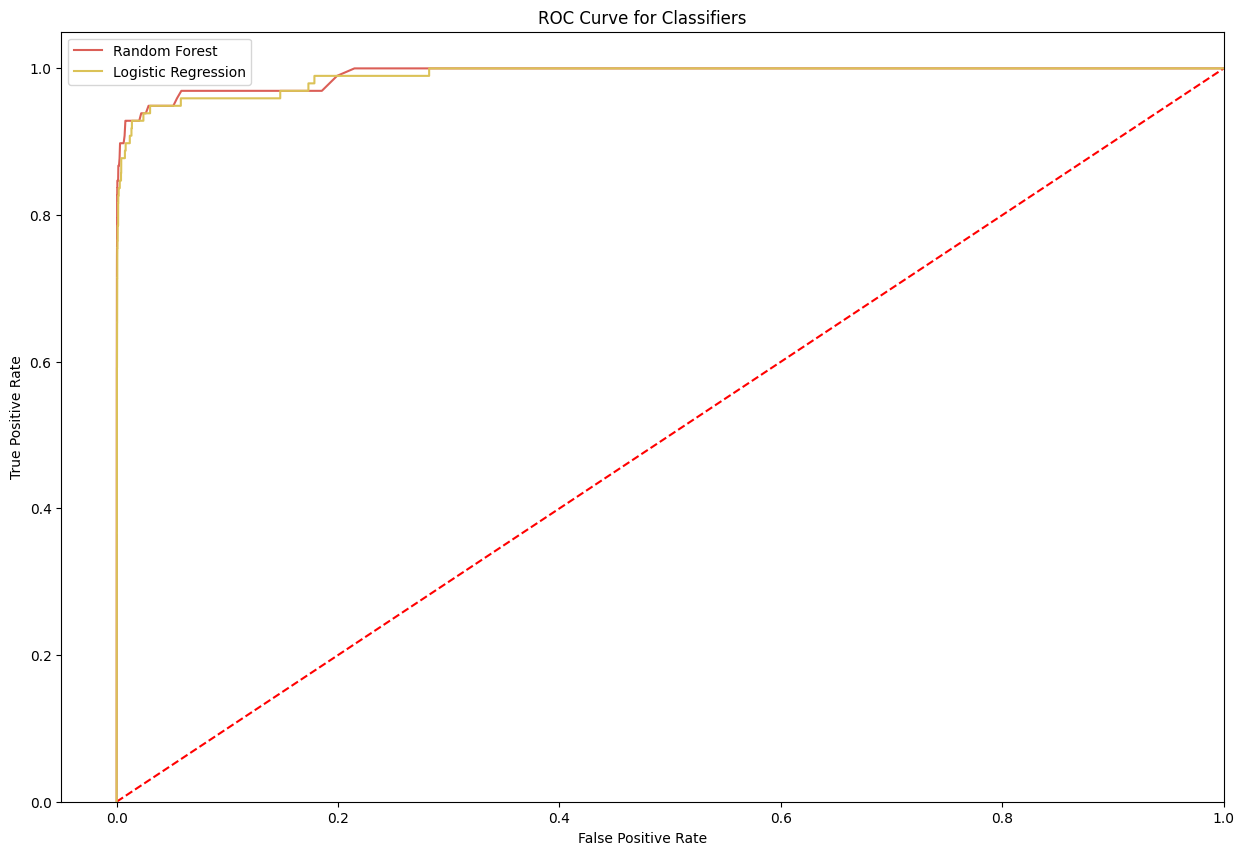

In [69]:
plot_roc_curves(roc_curves)


III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>


correlating
<a id="correlating"></a>
